# **Connect4 game with Deep Q-Learning**

## **Reinforcement Learning**
The goal of reinforcement learning is to maximize an agent's reward by performing a series of actions in response to a dynamic environment.

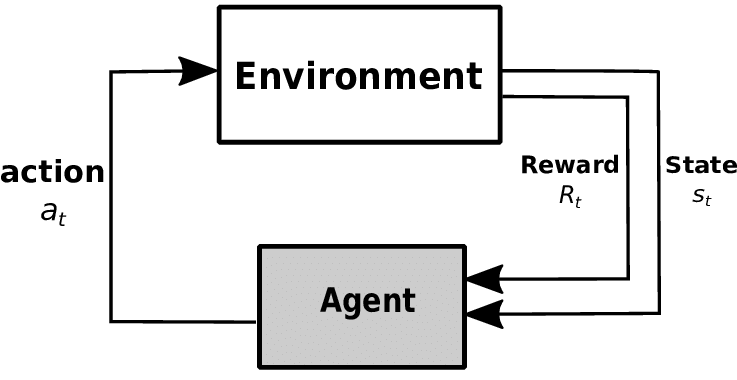

The following are some key concepts that describe the fundamental parts of an RL problem: :<br>
* **Environment**: The physical environment in which the agent operates.<br>
* **State**: The agent's current status <br>
* **Reward**: Feedback from the environment<br>
* **Policy**: A method for mapping the state of an agent to actions. <br>
* **Value**: Future reward that an agent will earn if he takes a specific action in a specific state <br>



RL algorithms are divided into two types: 


1.  An algorithm that calculates the optimal policy without using or estimating the transition and reward functions is known as a **model-free algorithm**. 
2.   An algorithm that determines the optimal policy using The transition and the reward function is known as **model-based algorithm**.




# **Q-learning model**

**Q-learning** is a model-free algorithm that can be used to create a self-playing Connect4 agent.
It is based on the concept of updating Q values, which represent the value of doing an action **a** in state **s**.
The Q-learning algorithm is built around the following value updating rule. 

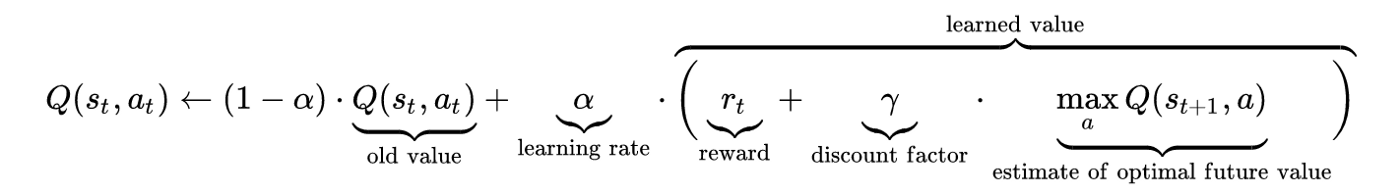

The agent maintains a Q(S,A) table, where S denotes the set of states and A denotes the set of actions. 
the Q-Table is used to compute the maximum expected future rewards for an action **a** at each state.
<br>
The equation above simply updates the specific location of the Q-Table that corresponds to the current observation based on the expected reward. 

The state of a Connect 4 board during a game is shown in the image above as an example observation from the standpoint of the Connect 4 environment, to better understand the nature of Q-learning. 

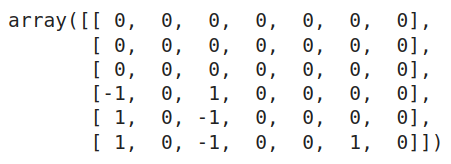

The agent receives this arrangement of previously played coins as an observation and stores it in the Q-Table. <br>
basically, the agent will question himself what he did the last time he encountered this observation and what action he will take to do better this time. 

# **The Limitations of Q-Learning**

We may try to store all potential (action, state) combinations and compute the optimal action if we played a smaller game.<br>
In its most basic form, Connect Four has 4531985219092 unique possible states.
It is impossible to keep track of all of these combinations due to hardware limitations. <br>
If we suppose that there is some form of algorithm that can take an observation, along with some sort of loss function calculated from the reward, and generalize about the observed environment in order to choose a single output (or action), we won't have to store as many environment observations.Fortunately,
Deep Neural Networks are a technology aimed at just this problem.

# **Deep Q-Learning Network**

In [ ]:
!pip install tensorflow==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2

In [1]:
import gym 
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 
import numpy as np
import random
import os

In [ ]:
NUM_ROWS = 6
NUM_COLS = 7
NUM2WIN = 4

In [ ]:
class CustumEnv(Env):
    NUM_ROWS = 6
    NUM_COLS = 7
    NUM2WIN = 4
    def __init__(self):
        # Actions we can take: throw the rock in one of the 7 column
        self.action_space = Discrete(NUM_COLS)
        # state matrix
        self.observation_space = Box(low=np.array([-1 for i in range(7*6)]).reshape(6,7), 
                                     high=np.array([1 for i in range(7*6)]).reshape(6,7),
                                     dtype=np.int8)
        # starting borad matrix
        self.state = np.zeros((6,7))
        
    def step(self, action,player): 
        #action=column number
        # Apply action
        # throw the rock on the top of the existing/empty selected column
        j = 0
        #print("Before Action")
        #print(self.state)
        #print(self.state)
        while j + 1 < self.NUM_ROWS and self.state[j + 1][action] == 0:
            j += 1
        info = {}    
        if self.state[j][action]!=0:
          self.state[j][action]!=np.nan
          reward=-10000
          done=True
          winner="overflow"
          info["winner"]=winner
          return self.state,reward,done,info
        self.state[j][action] = player
        #print("After Action")
        #print(self.state)

        winner=""
        # reward
        done = False
        reward = 0
        for i in range(self.NUM_ROWS - self.NUM2WIN + 1):
            for j in range(self.NUM_COLS - self.NUM2WIN + 1):
                sub_state = self.state[i:i + self.NUM2WIN, j:j + self.NUM2WIN]
                if np.max(np.sum(sub_state, axis=0)) == self.NUM2WIN or np.max(np.sum(sub_state, axis=1)) == self.NUM2WIN or np.trace(sub_state) == self.NUM2WIN or np.trace(np.transpose(sub_state)) == self.NUM2WIN: # human having 4 consecutive pieces in a column or row or both diagonals
                    done = True
                    reward = -10000
                    winner="Human"
                elif np.min(np.sum(sub_state, axis=0)) == -self.NUM2WIN or np.min(np.sum(sub_state, axis=1)) == -self.NUM2WIN or np.trace(sub_state) == -self.NUM2WIN or np.trace(np.transpose(sub_state)) == -self.NUM2WIN:
                    done = True
                    reward = 10000
                    winner="Agent"
                
        # if -np.max(np.sum(self.state, axis=0))==np.sum(self.state[:,action]) and not done:
        #           reward=1   
        if not done:
            reward=-1

        info["winner"]=winner
        
        # Return step information
        return self.state, reward, done,info
    
    def reset(self):
        # Reset
        self.state = np.zeros((6,7))
        return self.state

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

from collections import deque
import time
import random

RANDOM_SEED = 5
tf.random.set_seed(RANDOM_SEED)

env = CustumEnv()
env.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Action Space: {}".format(env.action_space))
print("State space: {}".format(env.observation_space))

Action Space: Discrete(7)
State space: Box(-1, 1, (6, 7), int8)


In [ ]:
# An episode a full game
train_episodes = 6000
test_episodes = 100

def agent(state_shape, action_shape):
    """ The agent maps X-states to Y-actions
    e.g. The neural network output is [.1, .7, .1, .3]
    The highest value 0.7 is the Q-Value.
    The index of the highest action (0.7) is action #1.
    """
    #print("state_shape: ",state_shape)
    #print("action shape: ",action_shape)
    learning_rate = 0.001
    init = tf.keras.initializers.HeUniform()
    model = keras.Sequential()
    model.add(keras.layers.Dense(48, input_shape=state_shape, activation='relu', kernel_initializer=init,))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(16, activation='relu', kernel_initializer=init,
    kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=keras.regularizers.l2(1e-4),
    activity_regularizer=keras.regularizers.l2(1e-5)))
    model.add(keras.layers.Dense(action_shape, activation='linear', kernel_initializer=init))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
    return model

def get_qs(model, state, step):
    return model.predict(state.reshape([1, state.shape[0]]))[0]

def train(env, replay_memory, model, target_model, done):
    learning_rate = 0.7 # Learning rate
    discount_factor = 0.618

    MIN_REPLAY_SIZE = 1000
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return
    env.reset()
    batch_size = 64 * 2
    mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([transition[0] for transition in mini_batch])
    current_qs_list = model.predict(current_states)
    new_current_states = np.array([transition[3] for transition in mini_batch])
    future_qs_list = target_model.predict(new_current_states)

    X = []
    Y = []
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        try:
          current_qs[:,action] = (1 - learning_rate) * current_qs[:,action] + learning_rate * max_future_q
        except:
          print(action)
          print(current_qs.shape)
        X.append(observation)
        Y.append(current_qs)
    model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

In [ ]:
epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
max_epsilon = 1 # You can't explore more than 100% of the time
min_epsilon = 0.01 # At a minimum, we'll always explore 1% of the time
decay = 0.01

# 1. Initialize the Target and Main models
# Main Model (updated every 4 steps)
model = agent(env.observation_space.shape, env.action_space.n)
# Target Model (updated every 100 steps)
target_model = agent(env.observation_space.shape, env.action_space.n)
target_model.set_weights(model.get_weights())

replay_memory = deque(maxlen=50_000)

target_update_counter = 0

# X = states, y = actions
X = []
y = []

steps_to_update_target_model = 0
n_wins=0
train_list_performace=[]
for episode in range(train_episodes):
    total_training_rewards = 0
    observation = env.reset()
    done = False
    human_play=True
    stop=100
    
    while not done:
        if human_play:
          action = np.random.choice(np.arange(0,7))
          env.step(action,1)
          human_play=False  
        
        else:
          stop-=1
          steps_to_update_target_model += 1
          human_play=True
          random_number = np.random.rand()
          # 2. Explore using the Epsilon Greedy Exploration Strategy
          if random_number <= epsilon:
              # Explore
              action = env.action_space.sample()
              print("Taking a random walk")
          else:
              # Exploit best known action
              # model dims are (batch, env.observation_space.n)
              encoded = observation
              #encoded_reshaped = encoded.reshape(1,encoded_reshaped[0],encoded_reshaped[1],1)
              #print(encoded_reshaped.shape)
              predicted = model.predict(observation)
              #print("predicted: ",predicted.shape)
              action = predicted.argmax(axis=1)[1]
              #print("action: ",action)
          temp=env.state   
          new_observation, reward, done, info = env.step(action,-1)
          if info["winner"]=="overflow":
            l=[i for i in range(env.action_space.n)]
            l.remove(action)

            action=np.random.choice(l)
            new_observation, reward, done, info = env.step(action,-1)
          if (temp==new_observation).all() and stop==-1:
            print("Action that was taken is: ",action)
            print(temp)
            print(new_observation)
          replay_memory.append([observation, action, reward, new_observation, done])

          # 3. Update the Main Network using the Bellman Equation

          observation = new_observation
          total_training_rewards += reward

          if done:
              print('Total training rewards: {} after n steps = {} with final reward = {} with a winner :{}'.format(total_training_rewards, episode, reward,info["winner"]))
              if info["winner"]=="Agent":
                n_wins+=1
              else:
                n_wins=max(n_wins-1,0) 
              train_list_performace.append(n_wins)   
              total_training_rewards += 1

              if steps_to_update_target_model >= 100:
                  print('Copying main network weights to the target network weights')
                  target_model.set_weights(model.get_weights())
                  steps_to_update_target_model = 0
              break
          else:
            print("Training at epoch = {}, with a reward {}".format(episode,reward))
        
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
env.close()

Streaming output truncated to the last 5000 lines.
Training at epoch = 5129, with a reward -1
Training at epoch = 5129, with a reward -1
Total training rewards: -10005 after n steps = 5129 with final reward = -10000 with a winner :Human
Training at epoch = 5130, with a reward -1
Training at epoch = 5130, with a reward -1
Training at epoch = 5130, with a reward -1
Total training rewards: 9997 after n steps = 5130 with final reward = 10000 with a winner :Agent
Training at epoch = 5131, with a reward -1
Training at epoch = 5131, with a reward -1
Training at epoch = 5131, with a reward -1
Training at epoch = 5131, with a reward -1
Training at epoch = 5131, with a reward -1
Training at epoch = 5131, with a reward -1
Training at epoch = 5131, with a reward -1
Training at epoch = 5131, with a reward -1
Training at epoch = 5131, with a reward -1
Total training rewards: -10009 after n steps = 5131 with final reward = -10000 with a winner :Human
Training at epoch = 5132, with a reward -1
Trainin

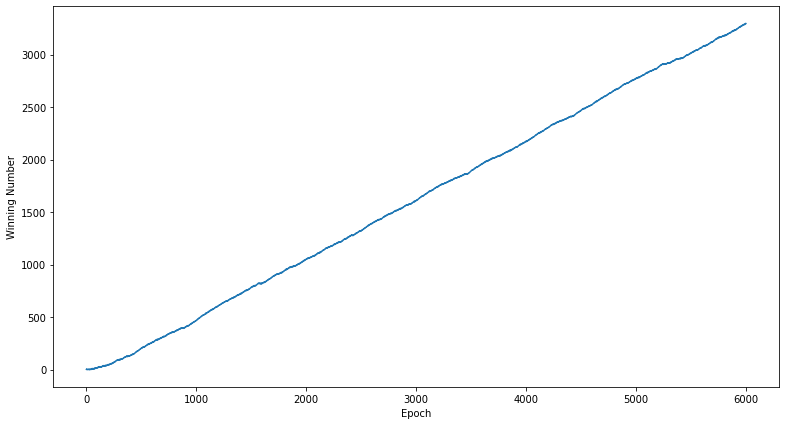

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13,7))
plt.xlabel("Epoch")
plt.ylabel("Winning Number")
plt.plot(range(0,len(train_list_performace)),train_list_performace)

In [ ]:
episodes = 20
n_wins=0
for episode in range(1, episodes+1):
    current_state = env.reset()
    done = False
    score = 0 
    human_play=True
    while not done:
        if human_play:
          env.step(np.random.choice(np.arange(0,7)),1)
          #print("Random is playing: ")
          human_play=False
          #print("Current State:")
          #print(current_state) 
          continue
        else: 
          #print("Agent is playing: ")
          action = model.predict(current_state)
          action = predicted.argmax(axis=1)[1]
          current_state, reward, done, info = env.step(action,-1)
          #print("Current action is: ",action)
          #print("Collected reward is: ",reward)
          score+=reward
          #print("Current State:")
          #print(current_state)  
          human_play=True
    if done:
      print("Game was done at episode {} with a score of {}".format(episode,score))   
      if info["winner"]=="Agent":
        n_wins+=1   
    print('Episode:{} Score:{}'.format(episode, score))

print("Total iterations won by agent is: {}".format(n_wins))

Game was done at episode 1 with a score of 9997
Episode:1 Score:9997
Game was done at episode 2 with a score of 9997
Episode:2 Score:9997
Game was done at episode 3 with a score of 9997
Episode:3 Score:9997
Game was done at episode 4 with a score of 9997
Episode:4 Score:9997
Game was done at episode 5 with a score of -10005
Episode:5 Score:-10005
Game was done at episode 6 with a score of -10005
Episode:6 Score:-10005
Game was done at episode 7 with a score of -10005
Episode:7 Score:-10005
Game was done at episode 8 with a score of -10004
Episode:8 Score:-10004
Game was done at episode 9 with a score of 9997
Episode:9 Score:9997
Game was done at episode 10 with a score of 9997
Episode:10 Score:9997
Game was done at episode 11 with a score of 9997
Episode:11 Score:9997
Game was done at episode 12 with a score of 9997
Episode:12 Score:9997
Game was done at episode 13 with a score of -10004
Episode:13 Score:-10004
Game was done at episode 14 with a score of 9997
Episode:14 Score:9997
Game

In [ ]:
model.save("DQN_C4.h5")

In [ ]:
env.action_space.n

7

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6, 48)             384       
_________________________________________________________________
dropout (Dropout)            (None, 6, 48)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6, 16)             784       
_________________________________________________________________
dense_2 (Dense)              (None, 6, 7)              119       
Total params: 1,287
Trainable params: 1,287
Non-trainable params: 0
_________________________________________________________________
